<a href="https://colab.research.google.com/github/gemme/resnet18/blob/resnet18/Resnet18__neumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import tensorflow.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D,Add, AveragePooling2D
from google.colab import drive
print(nn)
drive.flush_and_unmount()
drive.mount('/content/drive')
#_URL='https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip'
_URL='file:///content/drive/MyDrive/pneumonia2.zip'
zip_dir = tf.keras.utils.get_file('pneumonia2.zip', origin=_URL, extract=True,cache_dir='/content',archive_format='auto')
print(zip_dir)


<module 'tensorflow.nn' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/nn/__init__.py'>
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
2463365435/2463365435 [==============================] - 32s 0us/step
/content/datasets/pneumonia2.zip


In [12]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2
import tensorflow
import keras
from keras.metrics import Recall
from keras import Model, callbacks
from keras.layers import Input, Dense, add, Conv2D, MaxPool2D
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, ZeroPadding2D, RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import activations
from tensorflow.keras.regularizers import l2
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [13]:
train_path = '/content/datasets/chest_xray/train'
valid_path = '/content/datasets/chest_xray/val'
test_path = '/content/datasets/chest_xray/test'

In [14]:
BATCH_SIZE = 64
EPOCHS = 20
IMAGE_SIZE = (200, 200)
class_types=['NORMAL', 'PNEUMONIA']
train_dataset = image_dataset_from_directory(train_path,
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

valid_dataset = image_dataset_from_directory(valid_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

test_dataset = image_dataset_from_directory(test_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)


rescale = Rescaling(scale=1.0 / 255)
train_dataset = train_dataset.map(lambda image, label: (rescale(image), label))
valid_dataset  = valid_dataset.map(lambda image, label: (rescale(image), label))
test_dataset  = test_dataset.map(lambda image, label: (rescale(image), label))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [28]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    RandomFlip(mode='horizontal'), # meaning, left-to-right
    # RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    RandomRotation(factor=0.20),
    # RandomTranslation(height_factor=0.1, width_factor=0.1),
])
ex = next(iter(train_dataset.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    # plt.subplot(4, 4, i+1)
    # plt.imshow(tf.squeeze(image))
    # plt.axis('off')
# plt.show()

<Figure size 720x720 with 0 Axes>

In [29]:
cnt_imgs = 16  # we take 8 images for each class
norm_path = train_path + '/NORMAL'
pneumonia_path = train_path + '/PNEUMONIA'
norm_imgs = os.listdir(norm_path)[:cnt_imgs]
pneumonia_imgs = os.listdir(pneumonia_path)[:cnt_imgs]

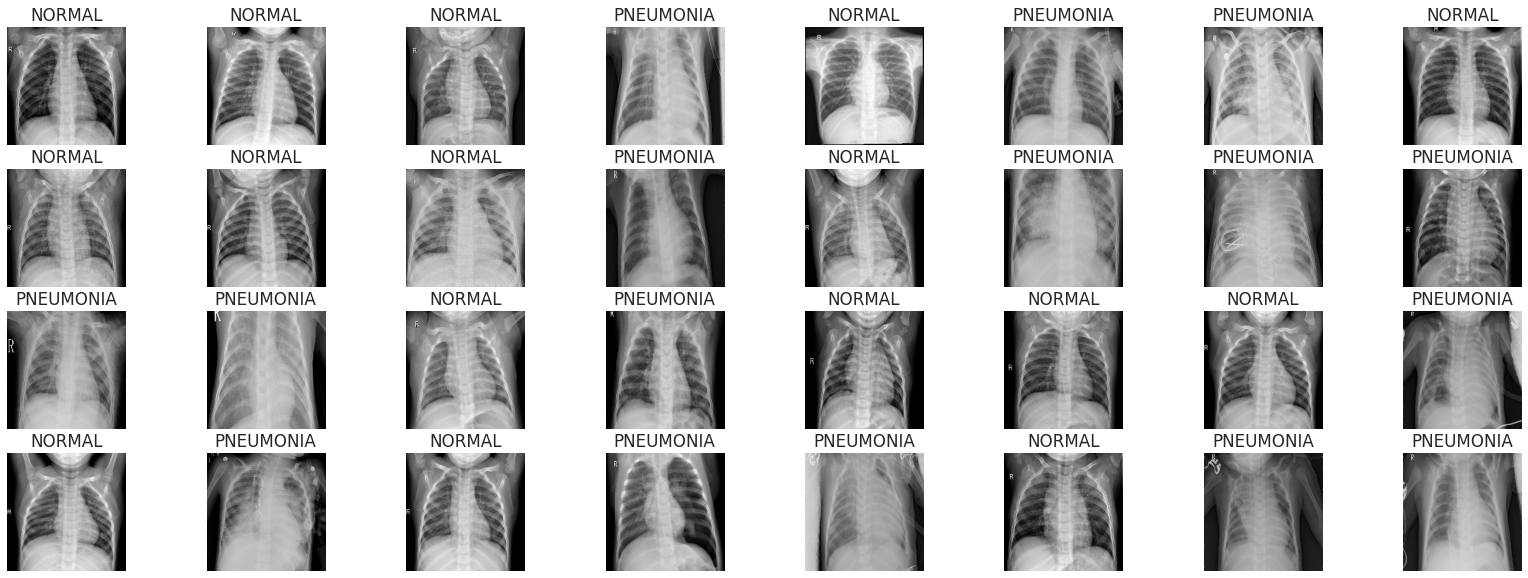

In [30]:
counter = 0
norm_imgs_path = [norm_path + '/' + i for i in norm_imgs]
pneumonia_imgs_path = [pneumonia_path + '/' + j for j in pneumonia_imgs]
all_imgs = norm_imgs_path + pneumonia_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(train_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

In [31]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [train_path, valid_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_NORMAL = check_cnt_label('NORMAL')
CNT_PNEUMONIA = check_cnt_label('PNEUMONIA')

In [32]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['NORMAL', 'PNEUMONIA'],
    y=[CNT_NORMAL, CNT_PNEUMONIA],
    name='Primary Product',
    marker_color='indianred',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [33]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", use_bias=False)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", use_bias=False)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), padding="same", use_bias=False)
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,padding="same", use_bias=False)
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        print(inputs.shape)
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
'''
inputs = Input(shape=(IMAGE_SIZE + (3,)))

x = Conv2D(32, (3, 3), activation='elu')(inputs)
x = Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_3_output = add([x, block_2_output])

x = Conv2D(128, (3, 3), activation='elu')(block_3_output)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
'''

In [34]:
# model = Model(inputs, output)
resnet18_model = ResNet18(1)
inputs = Input(shape=(IMAGE_SIZE + (3,)))
print(inputs.shape)
resnet18_model.build(input_shape=(None, 200, 200, 3))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(None, 200, 200, 3)
(None, 200, 200, 3)
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [36]:
# model.compile(optimizer='Adam',
#              loss='binary_crossentropy',
#              metrics=[Recall()])

# restnet 50
# resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])

# resnet50_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[Recall()])

from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
resnet18_model.compile(optimizer = "adam",loss='binary_crossentropy', metrics=[Recall()]) 
resnet18_model.summary()


Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9408      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74240     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 74240     
 )                                                               
                                                         

In [37]:
# history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=CALLBACKS)

batch_size=64 # test with 64, 128, 256

#resnet_train = resnet50_model.fit(train_dataset, 
                                  #epochs=160, 
                                  # steps_per_epoch=train_dataset.shape[0]/batch_size, 
                                  # validation_steps=valid_dataset.shape[0]/batch_size, 
                                  #validation_data=valid_dataset, 
                                  #callbacks=[lrdecay])
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="accuracy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(train_dataset) / 256
#history = resnet18_model.fit(aug.flow(train_dataset,valid_dataset,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(train_dataset, valid_dataset),callbacks=[es])
history = resnet18_model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=20,
                             batch_size = 64)

Epoch 1/20
(None, 200, 200, 3)
(None, 200, 200, 3)
82/82 [==============================] - 45s 371ms/step - loss: 0.3025 - recall: 0.9252 - val_loss: 50.2576 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 31s 350ms/step - loss: 0.1030 - recall: 0.9768 - val_loss: 9.9329 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 32s 354ms/step - loss: 0.0850 - recall: 0.9791 - val_loss: 4.6873 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 32s 352ms/step - loss: 0.0818 - recall: 0.9788 - val_loss: 5.8941 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 33s 372ms/step - loss: 0.0810 - recall: 0.9806 - val_loss: 0.6010 - val_recall: 0.7500
Epoch 6/20
82/82 [==============================] - 32s 355ms/step - loss: 0.0596 - recall: 0.9868 - val_loss: 5.0669 - val_recall: 1.0000
Epoch 7/20
82/82 [==============================] - 32s 357ms/step - loss: 0.0480 - recall: 0.9858 - val_loss: 5.6237 - val_r

In [38]:
test_result = resnet18_model.evaluate(test_dataset)
train_result = resnet18_model.evaluate(train_dataset)

82/82 [==============================] - 27s 301ms/step - loss: 0.0356 - recall: 0.9843


In [39]:
print(f'Metric (Recall) on test set: {test_result[1]}')
print(f'Metric (Recall) on train set: {train_result[1]}')

Metric (Recall) on test set: 0.9846153855323792
Metric (Recall) on train set: 0.9842580556869507


In [42]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['recall'],'bo--', label = "recall")
    plt.plot(history.history['val_recall'], 'ro--', label = "val_recall")
    plt.title("train_accuracy vs val_recall")
    plt.ylabel("recall")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

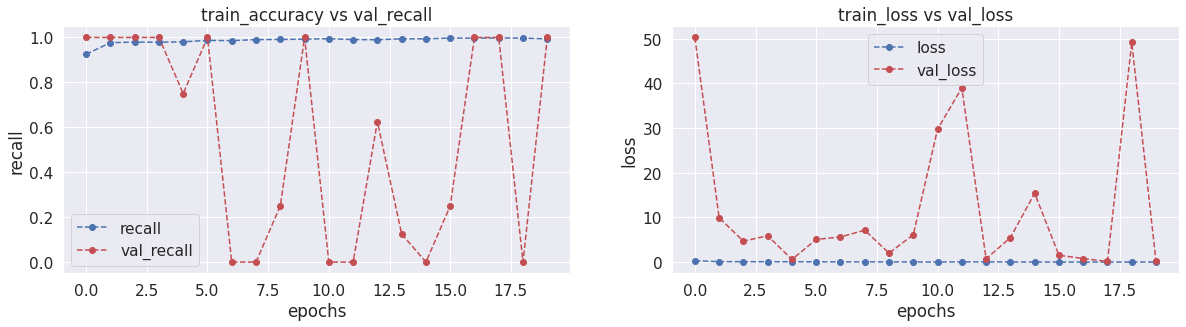

In [43]:
plot_accuracy_loss(history)